In [4]:
from geoband.API import *

import folium
import json
import geopandas as gpd

import pandas as pd
import numpy as np
import pprint

import fiona

import os

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['font.family'] = 'Malgun Gothic'

# import matplotlib.font_manager as fm

# 설치된 폰트 출력
# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

In [6]:
df2_mf = pd.read_csv('2.광양시_재활용품분리수거_장려금지급내역(수정).csv')
incentive = [70, 40, 30, 150, 200, 600, 200, 300, 1000]

for i in range(len(incentive)):
    df2_mf.iloc[:, i+4] = df2_mf.iloc[:, i+4] / incentive[i]

# 각 아파트/동별로 그룹화 하여 평균을 냄.(단위: kg)
    
df2_apt = df2_mf[['emd_nm','glass', 'pet', 'plastic','lamp', 'vinyl', 'battery', 'carton', 'smallappliance', 'hp']].groupby(df2_mf['complex_nm']).mean().round(2)
df2_dong = df2_mf[['glass', 'pet', 'plastic','lamp', 'vinyl', 'battery', 'carton', 'smallappliance', 'hp']].groupby(df2_mf['emd_nm']).mean().round(2)


In [7]:
# df2_apt.reset_index()
# df2_dong.reset_index()

In [8]:
df2_dong['total'] = df2_dong.sum(axis = 1)
recycle_df = pd.DataFrame(df2_dong.sum())
recycle_df = recycle_df.drop(index = 'total')

# recycle_df=recycle_df.reset_index()
# recycle_df.columns=['recycle_nm', 'amount']
# recycle_df

## 항목별 폐기물 발생량 
- 어떤 항목의 재활용품이 주로 많이 발생하는지 확인
- 유리, 페트, 플라스틱이 가장 많이 배출되었으며, 기타 램프, 비닐, 배터리, 폐종이류는 적게 배출되었고, 소형 가전이나 휴대폰은 거의 배출되지 않았다.
- 이 중에서도 페트와 플라스틱이 가장 많이 발생.
- 캔류, 알루미늄은 장려금 교부대상에서 빠진 듯.

- 다른 배출품목에 비해 유리, 페트, 플라스틱이 정말 많이 나왔는데, 이걸 따로 봐야 할지 고민.

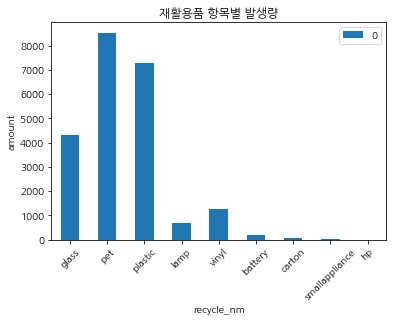

In [9]:
recycle_df.plot(kind='bar', rot=45)
plt.title("재활용품 항목별 발생량")
plt.xlabel("recycle_nm")
plt.ylabel("amount")
plt.show()

## 동별로 폐기물 발생 현황 비교.

- 각 동별로 폐기물 배출 현황은 어떻게 구성되어 있는지 비교.
- 금호동만 과하게 높게 나오고, 봉강면, 옥곡면과 같이 일부 품목만 배출하는 지역의 경우에는 지표가 매우 낮게 나왔다.
- 왜 이런 결과가 나왔는지 데이터를 살펴볼 필요가 있다.
- '이상치'의 기준을 정해서, 데이터 수집이 잘 안 된 경우를 제거해 볼 수 있을 것.


- 동별로 배출량이 너무 다른데, "발생량"과 "배출량"은 다르므로, 발생량을 예측해 볼 것인지, 그냥 배출량을 그대로 가져다 쓸 것인지 고민해야 할 듯.
- 발생량 예측) 금호동의 배출량 통계가 완벽하게 데이터가 수집된 것이라고 가정하고, 금호동의 아파트 정보를 가지고 회귀모델을 만들어 다른 동에 적용.
- 이유: 금호동 인구만 특별하게 높은 것이 아닌데, 다른 지역 배출량에 비해 금호동만 유독 배출량이 높음. 이거는 금호동이 쓰레기를 많이 배출하는 것이 아니라, 다른 지역의 쓰레기 배출량이 제대로 집계가 안 되었다는 것이 맞다고 봐야 할 거 같음.


- 배출량만 가지고 쓴다면) 금호동은 12개소를 따로 넣기로 하였으므로 아예 빼고 계산하고, 다른 지역들끼리 비교하여 입지선정.

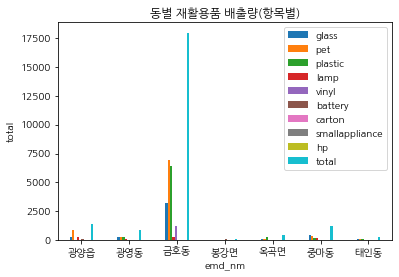

In [10]:
df2_dong.plot(kind='bar', rot=0)
plt.title("동별 재활용품 배출량(항목별)")
plt.xlabel("emd_nm")
plt.ylabel("total")
plt.show()

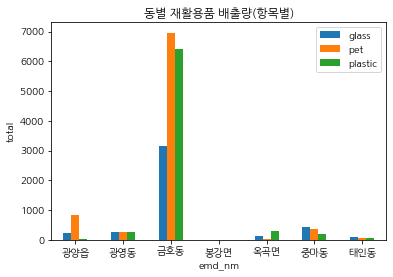

In [11]:
df2_dong[['glass', 'pet', 'plastic']].plot(kind='bar', rot=0)
plt.title("동별 재활용품 배출량(항목별)")
plt.xlabel("emd_nm")
plt.ylabel("total")
plt.show()

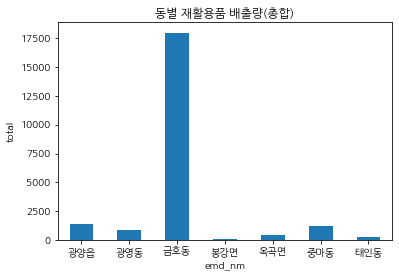

In [12]:
df2_dong['total'].plot(kind='bar', rot=0)
plt.title("동별 재활용품 배출량(총합)")
plt.xlabel("emd_nm")
plt.ylabel("total")
plt.show()

## 아파트별 배출량통계 확인.
- 특정 항목만을 배출한 주거단지 => 제외.
- 근거: Q&A 에 따르면, "모든 수거항목"을 골고루 수거하는 곳이 목적이므로, 일부 1~2품목 위주로만 쓰레기가 발생한 곳은 제외하는 것이 맞을듯.
- 주거단지 내에 설치되어야 하므로, 학교나 기타 단체는 제외.
=> 내 생각엔, 1인 쓰레기 발생량이 크게 차이가 없다는 가정 하에, 배출량 상위 20개 아파트의 값을 기준으로 회귀를 돌린 다음 나머지 하위 40개는 예측을 해서 넣는 것이 맞는 것 같음.((상위 20, 하위 40의 기준은 없음. 자세한 기준이 더 정해지면 좋을것.))

In [34]:
pd.set_option('display.max_rows', 100)
df2_apt['total'] = df2_apt.sum(axis = 1)
df2_apt.sort_values(by = ['total'], ascending = False, inplace = True)

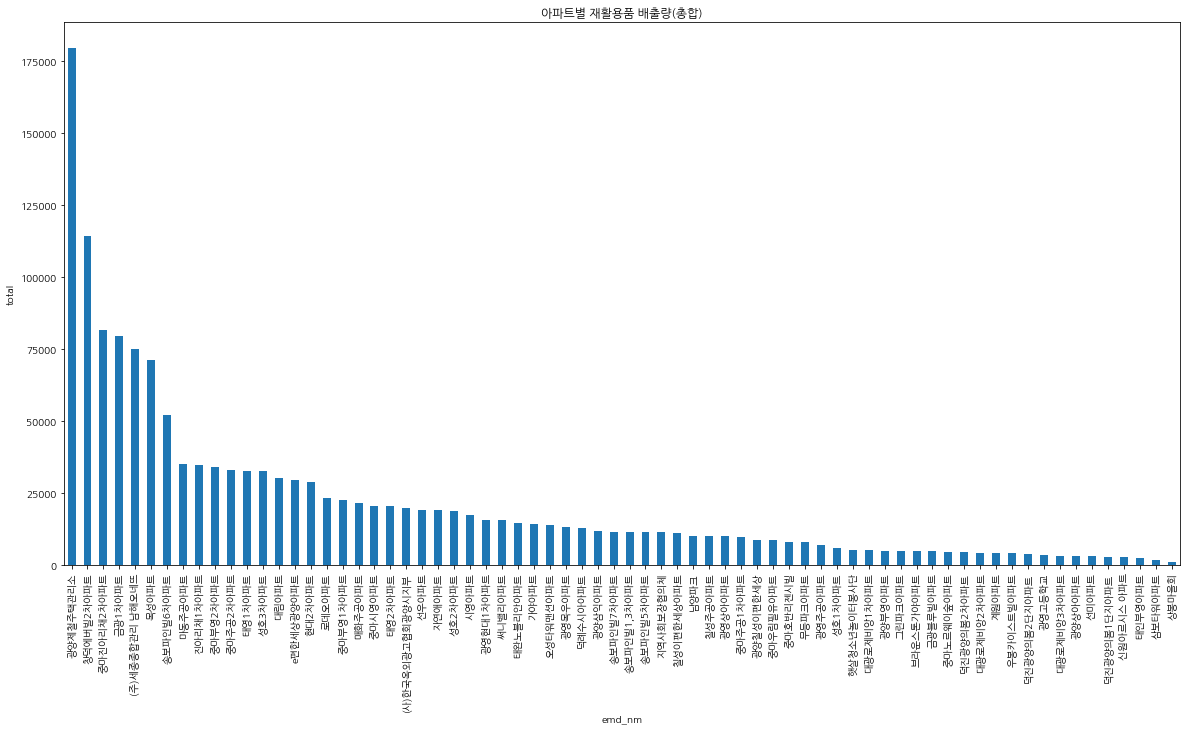

In [35]:
plt.figure(figsize = (20, 10))
df2_apt['total'].plot(kind='bar', rot=90)
plt.title("아파트별 재활용품 배출량(총합)")
plt.xlabel("emd_nm")
plt.ylabel("total")
plt.show()

## 추가적으로 생각해 볼 사항.
- 어떤 재활용품을 주로 보면 좋을지도 근거가 있으면 좋을 듯. 모든 재활용품을 다 수거하는 로봇의 설치가 목적이라고 했지만, 그 중에서도 중요하게 수거되어야 하는 항목이 존재할 것임. 그거 근거를 찾아 보기.

- 찾아서, 가중치를 줄 수 있을듯.